In [1]:
%matplotlib inline
import glob, os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
pd.options.display.max_rows = 200

plt.rcParams['figure.figsize'] = [10, 5]
plt.rc('font', size=20)



# Loading Dataset

## IOT Devices

The dataset has been extracted at `ROOT_PATH`, containing the data for each IOT device. There are 9 devices in total. There are folders for each IOT device containing `benign_traffic.csv` and further two folders for `gafgyt_attacks` and `mirai_attacks`

## Loading CSVs into Pandas
We will create pandas dataframe for each botnet attack on each IOT device. For each datafram we will combine the attack traffic with the benign traffic add the following column:
- `traffic_type` : benign or attack (0 or 1)


In [4]:
import pandas as pd
import os

ROOT_PATH = r'C:\Users\jessm\Desktop\HonoursProject\N-BaIoT_Dataset'

train_dev = 'Danmini_Doorbell'
train_bot = 'mirai'
test_dev = '838_Security_Cam'
test_bot = 'mirai'

def load_device_data(root_path, device, botnet):
    # Initialize list to hold dataframes
    dfs = []
    
    # Load attack csvs
    attack_path = os.path.join(root_path, device, botnet + '_attacks')
    attack_files = [os.path.join(attack_path, f) for f in os.listdir(attack_path) if f.endswith('.csv')]
    
    for af in attack_files:
        csv_df = pd.read_csv(af)
        csv_df['traffic_type'] = 'attack'
        dfs.append(csv_df)
    
    # Load benign csv
    benign_file = os.path.join(root_path, device, 'benign_traffic.csv')
    benign_df = pd.read_csv(benign_file)
    benign_df['traffic_type'] = 'benign'
    dfs.append(benign_df)
    
    # Combine all dataframes in the dfs list into a single dataframe
    return pd.concat(dfs, axis=0)

train_df = load_device_data(ROOT_PATH, train_dev, train_bot)
test_df = load_device_data(ROOT_PATH, test_dev, test_bot)


In [5]:
train_df.shape

(701648, 116)

In [6]:
test_df.shape

(527851, 116)

In [7]:
train_df['traffic_type'].value_counts()

attack    652100
benign     49548
Name: traffic_type, dtype: int64

In [8]:
test_df['traffic_type'].value_counts()

attack    429337
benign     98514
Name: traffic_type, dtype: int64

<Axes: title={'center': 'Test Traffic'}>

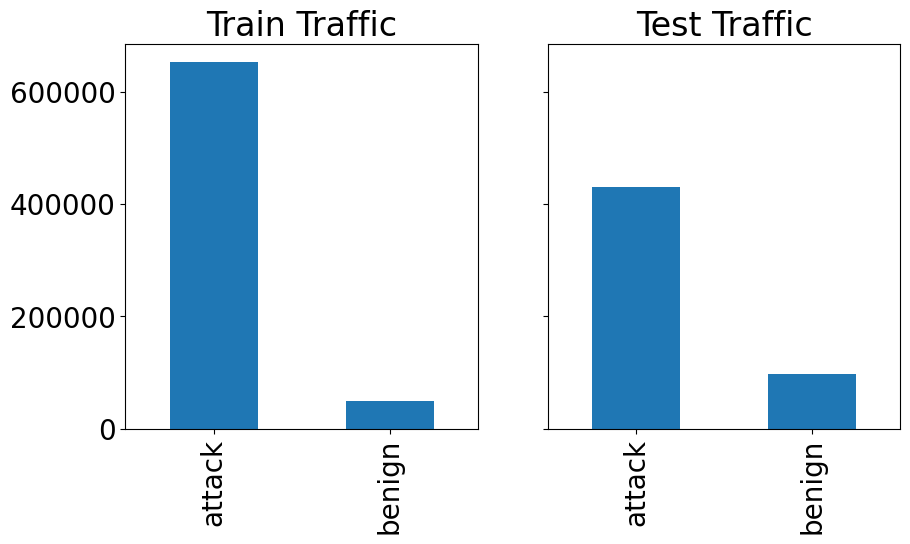

In [9]:
fig, axes = plt.subplots(1,2, figsize=(10,5), squeeze=False, sharey=True)
#fig.tight_layout()

train_df['traffic_type'].value_counts().plot(kind='bar', title='Train Traffic', y='count', ax=axes[0,0])
test_df['traffic_type'].value_counts().plot(kind='bar', title='Test Traffic', y='count', ax=axes[0,1])


# Modeling

### Pre processing
Convert the target column `traffic_type` to integer 0 = benigh, 1 = attack 

In [10]:
train_df.loc[ train_df['traffic_type']=='attack', 'traffic_type'] = 1
train_df.loc[ train_df['traffic_type']=='benign', 'traffic_type'] = 0
train_df['traffic_type'] = train_df['traffic_type'].astype(int)

test_df.loc[ test_df['traffic_type']=='attack', 'traffic_type'] = 1
test_df.loc[ test_df['traffic_type']=='benign', 'traffic_type'] = 0
test_df['traffic_type'] = test_df['traffic_type'].astype(int)

### Classifiers and training functions

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [3]:
clf = RandomForestClassifier()

## Train

In [4]:
X_train = train_df.drop(["traffic_type" ], axis=1)
y_train = train_df["traffic_type"]

X_test = test_df.drop(["traffic_type" ], axis=1)
y_test = test_df["traffic_type"]

clf.fit(X_train, y_train)
#y_preds = clf.predict(X_test)



NameError: name 'train_df' is not defined

## Test

In [14]:
y_preds = clf.predict(X_test)


## Evaluate

In [15]:
print(classification_report(y_test, y_preds, output_dict=False))


              precision    recall  f1-score   support

           0       0.74      0.97      0.84     98514
           1       0.99      0.92      0.96    429337

    accuracy                           0.93    527851
   macro avg       0.87      0.94      0.90    527851
weighted avg       0.94      0.93      0.93    527851



In [16]:
confusion_matrix(y_test, y_preds)

array([[ 95253,   3261],
       [ 33529, 395808]], dtype=int64)

# Balancing Training DataSet

### Add more benign traffic from other devices

In [17]:
benign_files = [
    os.path.join(ROOT_PATH, 'Danmini_Doorbell', 'benign_traffic.csv'),
    os.path.join(ROOT_PATH, 'Ecobee_Thermostat', 'benign_traffic.csv'),
    os.path.join(ROOT_PATH, 'Ennio_Doorbell', 'benign_traffic.csv'),
    os.path.join(ROOT_PATH, '838_Security_Cam', 'benign_traffic.csv'),
    os.path.join(ROOT_PATH, 'Samsung_Webcam', 'benign_traffic.csv'),
    os.path.join(ROOT_PATH, '1002_Security_Cam', 'benign_traffic.csv'),
    os.path.join(ROOT_PATH, '1003_Security_Cam', 'benign_traffic.csv')


]

for bf in benign_files:
    b_df = pd.read_csv(bf)
    print(b_df.shape)
    b_df['traffic_type'] = 0
    train_df = train_df.append(b_df)

(49548, 115)


C:\Users\jessm\AppData\Local\Temp\ipykernel_21824\515885696.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(b_df)


(13113, 115)


C:\Users\jessm\AppData\Local\Temp\ipykernel_21824\515885696.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(b_df)


(39100, 115)


C:\Users\jessm\AppData\Local\Temp\ipykernel_21824\515885696.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(b_df)


(98514, 115)


C:\Users\jessm\AppData\Local\Temp\ipykernel_21824\515885696.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(b_df)


(52150, 115)


C:\Users\jessm\AppData\Local\Temp\ipykernel_21824\515885696.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(b_df)


(46585, 115)


C:\Users\jessm\AppData\Local\Temp\ipykernel_21824\515885696.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(b_df)


(19528, 115)


C:\Users\jessm\AppData\Local\Temp\ipykernel_21824\515885696.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(b_df)


<Axes: title={'center': 'Test Traffic'}>

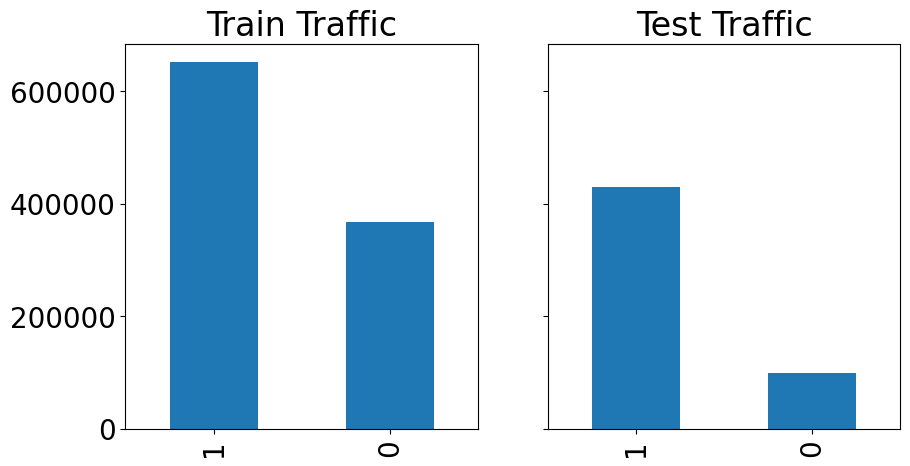

In [18]:
fig, axes = plt.subplots(1,2, figsize=(10,5), squeeze=False, sharey=True)
#fig.tight_layout()

train_df['traffic_type'].value_counts().plot(kind='bar', title='Train Traffic', y='count', ax=axes[0,0])
test_df['traffic_type'].value_counts().plot(kind='bar', title='Test Traffic', y='count', ax=axes[0,1])


In [19]:
train_df['traffic_type'].value_counts()

1    652100
0    368086
Name: traffic_type, dtype: int64

In [20]:
X_train = train_df.drop(["traffic_type" ], axis=1)
y_train = train_df["traffic_type"]

clf2 = KNeighborsClassifier()
clf2.fit(X_train, y_train)


KNeighborsClassifier()

In [21]:
y_preds = clf2.predict(X_test)


In [22]:
print(classification_report(y_test, y_preds, output_dict=False))


              precision    recall  f1-score   support

           0       0.60      0.99      0.75     98514
           1       1.00      0.85      0.92    429337

    accuracy                           0.88    527851
   macro avg       0.80      0.92      0.83    527851
weighted avg       0.92      0.88      0.89    527851



In [23]:
confusion_matrix(y_test, y_preds)

array([[ 97683,    831],
       [ 64529, 364808]], dtype=int64)